In [1]:


import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score


In [2]:
# ---------------------------
# Cell 1: Load raw CSVs
# ---------------------------
ACCOUNTS_CSV = "data/ravenstack_accounts.csv"
SUBS_CSV     = "data/ravenstack_subscriptions.csv"
USAGE_CSV    = "data/ravenstack_feature_usage.csv"
SUPPORT_CSV  = "data/ravenstack_support_tickets.csv"
CHURN_CSV    = "data/ravenstack_churn_events.csv"

accounts = pd.read_csv(ACCOUNTS_CSV)
subs     = pd.read_csv(SUBS_CSV)
usage    = pd.read_csv(USAGE_CSV)
support  = pd.read_csv(SUPPORT_CSV)
churn    = pd.read_csv(CHURN_CSV)

In [3]:
# ---------------------------
# Cell 2: Parse dates
# ---------------------------
def to_dt(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

to_dt(accounts, ["signup_date"])
to_dt(subs,     ["start_date", "end_date"])
to_dt(usage,    ["usage_date"])
to_dt(support,  ["submitted_at", "closed_at"])
to_dt(churn,    ["churn_date"])


In [4]:
# ---------------------------
# Cell 3: Quick ranges (sanity)
# ---------------------------
global_end = max([
    usage["usage_date"].max(),
    support["submitted_at"].max(),
    subs["end_date"].fillna(subs["start_date"].max()).max(),
    churn["churn_date"].max()
])

In [5]:
# ---------------------------
# Cell 4: Usage daily rollups
# usage table uses subscription_id; join to subs to get account_id
# ---------------------------
usage_with_acc = usage.merge(
    subs[["subscription_id","account_id"]].drop_duplicates(),
    on="subscription_id", how="left"
)
usage_with_acc["date"] = usage_with_acc["usage_date"].dt.date

usage_daily = (
    usage_with_acc.groupby(["account_id", "date"], as_index=False)
      .agg(
          events_all=("usage_count", "sum"),
          duration_secs=("usage_duration_secs", "sum"),
          errors=("error_count", "sum"),
          features_used=("feature_name", "nunique"),
          events_beta=("usage_count", lambda s: usage_with_acc.loc[s.index, "is_beta_feature"].astype(int).mul(s).sum()),
          beta_features_used=("is_beta_feature", lambda s: (s == True).sum())
      )
)


In [6]:
# ---------------------------
# Cell 5: Support daily rollups
# ---------------------------
support["date"] = support["submitted_at"].dt.date

def is_high_priority(val):
    p = str(val).lower()
    return int(p in ("high", "urgent", "p1", "critical"))

support_daily = (
    support.groupby(["account_id", "date"], as_index=False)
           .agg(
               tickets_opened=("ticket_id", "count"),
               tickets_high=("priority", lambda s: sum(is_high_priority(x) for x in s)),
               avg_csat=("satisfaction_score", "mean"),
               sla_breaches=("resolution_time_hours", lambda s: (s > 24).sum())
           )
)

In [7]:
# ---------------------------
# Cell 6: Subscription daily snapshot (expand rows per day)
# ---------------------------
subs_full = subs.copy()
# na end_date = still active -> use global_end
subs_full["end_date"] = subs_full["end_date"].fillna(global_end)

rows = []
for _, r in subs_full.iterrows():
    if pd.isna(r["start_date"]) or pd.isna(r["end_date"]):
        continue
    for d in pd.date_range(r["start_date"].date(), r["end_date"].date(), freq="D"):
        rows.append({
            "account_id": r["account_id"],
            "date": d.date(),
            "plan_tier": r["plan_tier"],
            "seats": r["seats"],
            "mrr": r["mrr_amount"],
            "is_trial": r["is_trial"],
            "upgrade_flag": r["upgrade_flag"],
            "downgrade_flag": r["downgrade_flag"]
        })

sub_daily = pd.DataFrame(rows)

In [8]:
# ---------------------------
# Cell 7: Build account×date panel
# ---------------------------
acc_min = accounts[["account_id", "signup_date"]].copy()
panels = []
for _, r in acc_min.iterrows():
    rng = pd.date_range(r["signup_date"].date(), global_end.date(), freq="D")
    panels.append(pd.DataFrame({"account_id": r["account_id"], "date": rng.date}))
panel = pd.concat(panels, ignore_index=True)

# Join all daily sources
panel = panel.merge(usage_daily, on=["account_id","date"], how="left")
panel = panel.merge(support_daily, on=["account_id","date"], how="left")
panel = panel.merge(sub_daily, on=["account_id","date"], how="left")

# Zero-fill count metrics; carry forward plan/is_trial
for col in ["events_all","duration_secs","errors","events_beta","features_used",
            "beta_features_used","tickets_opened","tickets_high","sla_breaches",
            "seats","mrr"]:
    if col in panel.columns:
        panel[col] = panel[col].fillna(0)

panel = panel.sort_values(["account_id","date"])
panel["avg_csat"]   = panel.groupby("account_id")["avg_csat"].ffill()
panel["plan_tier"]  = panel.groupby("account_id")["plan_tier"].ffill().bfill()
panel["is_trial"]   = panel.groupby("account_id")["is_trial"].ffill().bfill()


/var/folders/k_/kprh5hg12xd08lhcs28y8qn80000gp/T/ipykernel_12510/576838972.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  panel["is_trial"]   = panel.groupby("account_id")["is_trial"].ffill().bfill()


In [9]:
# ---------------------------
# Cell 8: Rolling features (7/14/28 day)
# ---------------------------
panel["date"] = pd.to_datetime(panel["date"])

def add_rollings(df):
    df = df.copy()
    # core sums
    for col in ["events_all","events_beta","tickets_opened","tickets_high","sla_breaches","errors","duration_secs"]:
        if col in df.columns:
            df[f"{col}_7d"]  = df[col].rolling(7,  min_periods=1).sum()
            df[f"{col}_14d"] = df[col].rolling(14, min_periods=1).sum()
            df[f"{col}_28d"] = df[col].rolling(28, min_periods=1).sum()
    # momentum
    if "events_all_7d" in df.columns and "events_all_28d" in df.columns:
        df["usage_delta_7v28"] = df["events_all_7d"] - (df["events_all_28d"] / 4.0)
    # seat delta & plan change
    if "seats" in df.columns:
        df["delta_seats_1d"] = df["seats"].diff()
    if "plan_tier" in df.columns:
        df["plan_changed_1d"] = (df["plan_tier"] != df["plan_tier"].shift(1)).astype(int)
    return df

panel = panel.groupby("account_id", group_keys=False).apply(add_rollings)

/var/folders/k_/kprh5hg12xd08lhcs28y8qn80000gp/T/ipykernel_12510/233401406.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  panel = panel.groupby("account_id", group_keys=False).apply(add_rollings)


In [10]:
# ---------------------------
# Cell 9: Label = churn within next 30 days (forward-looking)
# ---------------------------
first_churn = churn.groupby("account_id", as_index=False)["churn_date"].min()
first_churn = first_churn.rename(columns={"churn_date":"first_churn_date"})
panel = panel.merge(first_churn, on="account_id", how="left")

panel["days_to_churn"]  = (panel["first_churn_date"] - panel["date"]).dt.days
panel["churn_next_30d"] = ((panel["days_to_churn"] >= 0) & (panel["days_to_churn"] <= 30)).astype(int)

In [11]:
# ---------------------------
# Cell 10: Modeling set (time split)
# ---------------------------
FEATURES = [
    "events_all_7d","events_all_28d","usage_delta_7v28",
    "events_beta_28d",
    "tickets_opened_14d","tickets_high_14d","sla_breaches_14d",
    "errors_28d","duration_secs_28d",
    "seats","delta_seats_1d","plan_changed_1d","mrr"
]
# Keep only rows with all features present
daily = panel.dropna(subset=FEATURES + ["churn_next_30d"]).copy()

cutoff = pd.Timestamp("2024-10-01")
train = daily[daily["date"] <  cutoff]
test  = daily[daily["date"] >= cutoff]

Xtr = train[FEATURES].fillna(0).values
ytr = train["churn_next_30d"].astype(int).values
Xte = test[FEATURES].fillna(0).values
yte = test["churn_next_30d"].astype(int).values

In [12]:
# ---------------------------
# Cell 11: Fit baseline model (class_weight to fight imbalance)
# ---------------------------
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xte_s = scaler.transform(Xte)

clf = LogisticRegression(max_iter=400, class_weight="balanced")
clf.fit(Xtr_s, ytr)

proba = clf.predict_proba(Xte_s)[:,1]
auc   = roc_auc_score(yte, proba)
aupr  = average_precision_score(yte, proba)

print("AUC:", round(auc, 4), "| AUPRC:", round(aupr, 4), "| Base rate:", round(yte.mean(), 4))


AUC: 0.5111 | AUPRC: 0.0344 | Base rate: 0.0346


In [13]:
# ---------------------------
# Cell 12: Precision@fraction utilities
# ---------------------------
def precision_at_fraction(ytrue, scores, frac):
    k = max(1, int(frac * len(ytrue)))
    idx = np.argsort(-scores)[:k]
    return precision_score(ytrue[idx], np.ones_like(ytrue[idx])), k

for frac in (0.05, 0.10, 0.20):
    p, k = precision_at_fraction(yte, proba, frac)
    print(f"Precision@{int(frac*100)}% (k={k}):", round(p, 4))

Precision@5% (k=16303): 0.0187
Precision@10% (k=32606): 0.0245
Precision@20% (k=65212): 0.0386


In [14]:
# ---------------------------
# Cell 13: Transparent risk rules + top risk table
# ---------------------------
scored = test[["account_id","date"] + FEATURES + ["churn_next_30d"]].copy()
scored["score"] = proba

# Reason codes (easy to audit)
scored["rule_usage_drop"]        = (scored["usage_delta_7v28"] < 0).astype(int)
scored["rule_seat_shrink"]       = (scored["delta_seats_1d"] < 0).astype(int)
scored["rule_plan_change"]       = (scored["plan_changed_1d"] == 1).astype(int)
scored["rule_support_friction"]  = ((scored["tickets_high_14d"] >= 2) | (scored["sla_breaches_14d"] >= 1)).astype(int)
scored["rule_no_beta_engagement"]= (scored["events_beta_28d"] == 0).astype(int)
REASONS = ["rule_usage_drop","rule_seat_shrink","rule_plan_change","rule_support_friction","rule_no_beta_engagement"]
scored["risk_rules"] = scored[REASONS].sum(axis=1)

# One row per account (latest test date)
last_per_acc = scored.sort_values(["account_id","date"]).groupby("account_id", as_index=False).tail(1)
top = last_per_acc.sort_values("score", ascending=False).head(50)

# Save outputs (optional)
top_out = "data/top_risk_accounts.csv"
feat_out = "data/model_features_daily.csv"
top.to_csv(top_out, index=False)
daily[["account_id","date","churn_next_30d"] + FEATURES].to_csv(feat_out, index=False)

print("Saved:")
print(" - Top risks:", top_out)
print(" - Feature matrix (daily):", feat_out)

# Display top 10 for quick view (optional)
top_display_cols = ["account_id","date","score","churn_next_30d"] + REASONS + ["risk_rules","seats","mrr","events_all_28d","tickets_opened_14d"]
print("\nTop 10 At-Risk Accounts (sample):")
print(top[top_display_cols].head(10).to_string(index=False))

Saved:
 - Top risks: data/top_risk_accounts.csv
 - Feature matrix (daily): data/model_features_daily.csv

Top 10 At-Risk Accounts (sample):
account_id       date    score  churn_next_30d  rule_usage_drop  rule_seat_shrink  rule_plan_change  rule_support_friction  rule_no_beta_engagement  risk_rules  seats    mrr  events_all_28d  tickets_opened_14d
  A-fda07f 2024-12-31 0.646644               0                1                 0                 1                      0                        1           3   14.0 2786.0           312.0                 0.0
  A-7c83a1 2024-12-31 0.581147               0                0                 1                 0                      0                        1           2   17.0    0.0           108.0                 0.0
  A-f3ff05 2024-12-31 0.576964               0                0                 1                 1                      0                        1           3    2.0   38.0           144.0                 0.0
  A-db5e9e 2024-12-3

In [15]:
# === Cell A: Add richer churn signals to existing `panel` ===

# Guard: make sure required base columns exist
_req = ["account_id","date","events_all","events_beta","tickets_opened","tickets_high",
        "sla_breaches","errors","duration_secs","seats","mrr","churn_next_30d"]
missing = [c for c in _req if c not in panel.columns]
if missing:
    raise ValueError(f"Your `panel` is missing columns: {missing}. "
                     "Re-run the earlier cells that build the daily panel and rolling features.")

panel = panel.sort_values(["account_id","date"]).copy()

# If rolling windows weren't added yet, add minimal 7/14/28d sums we rely on here
def _ensure_roll(df):
    for base in ["events_all","events_beta","tickets_opened","tickets_high","sla_breaches","errors","duration_secs"]:
        for w in (7,14,28):
            col = f"{base}_{w}d"
            if col not in df.columns:
                df[col] = df.groupby("account_id")[base].transform(lambda s: s.rolling(w, 1).sum())
    return df

panel = _ensure_roll(panel)

# Volatility (28d std) for usage
if "events_all_28d_std" not in panel.columns:
    panel["events_all_28d_std"] = (panel.groupby("account_id")["events_all"]
                                         .transform(lambda s: s.rolling(28, 2).std()))

# Momentum
panel["usage_delta_7v28"] = panel["events_all_7d"] - (panel["events_all_28d"] / 4.0)

# Seat delta & plan change
panel["delta_seats_1d"]  = panel.groupby("account_id")["seats"].diff()
panel["plan_changed_1d"] = (panel.groupby("account_id")["plan_tier"].shift(1) != panel["plan_tier"]).astype(int)

# Recency features (days since last usage / beta usage / ticket)
panel["last_use_date"]   = panel["date"].where(panel["events_all"]  > 0)
panel["last_beta_date"]  = panel["date"].where(panel["events_beta"] > 0)
panel["last_tix_date"]   = panel["date"].where(panel["tickets_opened"] > 0)

panel["last_use_date"]  = panel.groupby("account_id")["last_use_date"].ffill()
panel["last_beta_date"] = panel.groupby("account_id")["last_beta_date"].ffill()
panel["last_tix_date"]  = panel.groupby("account_id")["last_tix_date"].ffill()

panel["days_since_usage"]  = (panel["date"] - panel["last_use_date"]).dt.days.fillna(9999)
panel["days_since_beta"]   = (panel["date"] - panel["last_beta_date"]).dt.days.fillna(9999)
panel["days_since_ticket"] = (panel["date"] - panel["last_tix_date"]).dt.days.fillna(9999)

# Ratios / utilization
panel["beta_share_28d"]  = panel["events_beta_28d"] / np.maximum(panel["events_all_28d"], 1)
panel["utilization_28d"] = panel["events_all_28d"] / np.maximum(panel["seats"], 1)

# Keep a clean feature list for modeling
FEATURES_XGB = [
    # usage volume & momentum
    "events_all_7d","events_all_28d","usage_delta_7v28","events_all_28d_std",
    # adoption depth
    "events_beta_28d","beta_share_28d","features_used","beta_features_used",
    # recency
    "days_since_usage","days_since_beta","days_since_ticket",
    # support friction
    "tickets_opened_14d","tickets_high_14d","sla_breaches_14d",
    # stability/errors
    "errors_28d","duration_secs_28d",
    # commercial state
    "seats","delta_seats_1d","plan_changed_1d","mrr",
    # utilization
    "utilization_28d"
]

print("✅ Added richer churn signals. Ready for XGBoost.")


✅ Added richer churn signals. Ready for XGBoost.


In [29]:
# === Cell B: Train XGBoost on daily rows with time-based split ===
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score

# Build model dataset
model_df = panel.dropna(subset=["churn_next_30d"]).copy()
for c in FEATURES_XGB:
    if c not in model_df.columns:
        model_df[c] = 0.0

X = model_df[FEATURES_XGB].fillna(0)
y = model_df["churn_next_30d"].astype(int)
dates = model_df["date"]

# Time split
CUT = pd.Timestamp("2024-10-01")
train_mask = dates < CUT
test_mask  = dates >= CUT

Xtr, ytr = X[train_mask].values, y[train_mask].values
Xte, yte = X[test_mask].values,  y[test_mask].values

# Class imbalance → scale_pos_weight
pos = ytr.sum()
neg = len(ytr) - pos
scale_pos_weight = float((neg / max(pos,1)) if pos > 0 else 1.0)

# Train XGBoost (fallback to GradientBoosting if xgboost not installed)
used_model = None
try:
    import xgboost as xgb
    clf = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        min_child_weight=1.0,
        reg_lambda=1.0,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale_pos_weight,
        n_jobs=4,
        random_state=42
    )
    clf.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    proba = clf.predict_proba(Xte)[:, 1]
    used_model = "xgboost"
    # Importance by gain
    booster = clf.get_booster()
    raw_imp = booster.get_score(importance_type="gain")  # dict: f0..fn -> gain
    # Map f0.. to human names
    feat_map = {f"f{i}": name for i, name in enumerate(FEATURES_XGB)}
    fi = (pd.DataFrame({"feature_key": list(raw_imp.keys()), "gain": list(raw_imp.values())})
            .assign(feature=lambda d: d["feature_key"].map(feat_map).fillna(d["feature_key"]))[
             ["feature","gain"]].sort_values("gain", ascending=False))
except Exception:
    from sklearn.ensemble import GradientBoostingClassifier
    clf = GradientBoostingClassifier(random_state=42)
    clf.fit(Xtr, ytr)
    proba = clf.predict_proba(Xte)[:, 1]
    used_model = "sklearn.GradientBoosting"
    fi = pd.DataFrame({"feature": FEATURES_XGB, "gain": np.nan})

# Metrics
auc  = roc_auc_score(yte, proba)
aupr = average_precision_score(yte, proba)
base = yte.mean()

def precision_at_fraction(ytrue, scores, frac):
    k = max(1, int(frac * len(ytrue)))
    idx = np.argsort(-scores)[:k]
    return float(precision_score(ytrue[idx], np.ones_like(ytrue[idx]))), k

p5,  k5  = precision_at_fraction(yte, proba, 0.05)
p10, k10 = precision_at_fraction(yte, proba, 0.10)
p20, k20 = precision_at_fraction(yte, proba, 0.20)

print(f"Model: {used_model}")
print(f"AUC: {auc:.4f} | AUPRC: {aupr:.4f} | Base rate: {base:.4f}")
print(f"Precision@5%  (k={k5}):  {p5:.4f}")
print(f"Precision@10% (k={k10}): {p10:.4f}")
print(f"Precision@20% (k={k20}): {p20:.4f}")

print("\nTop signals (by gain):")
print(fi.head(15).to_string(index=False))


Model: xgboost
AUC: 0.6287 | AUPRC: 0.0565 | Base rate: 0.0347
Precision@5%  (k=16307):  0.0697
Precision@10% (k=32614): 0.0686
Precision@20% (k=65228): 0.0630

Top signals (by gain):
           feature       gain
 days_since_ticket 850.846985
   days_since_beta 756.010132
             seats 619.582764
  days_since_usage 601.647034
               mrr 484.631714
    delta_seats_1d 445.903320
    events_all_28d 343.210846
 duration_secs_28d 330.919098
events_all_28d_std 323.057983
   plan_changed_1d 290.314270
        errors_28d 266.103607
   utilization_28d 239.008530
   events_beta_28d 231.254181
    beta_share_28d 229.876450
  sla_breaches_14d 155.614914


<Figure size 640x480 with 0 Axes>

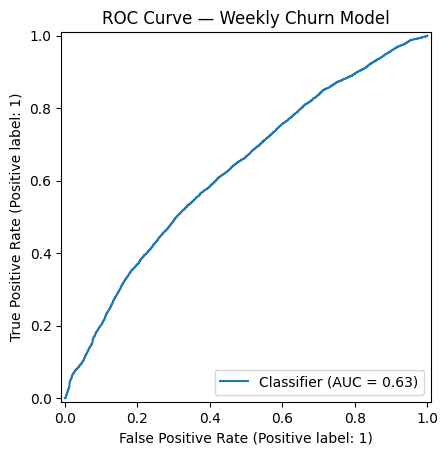

In [32]:
## ROC curve
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

plt.figure()
RocCurveDisplay.from_predictions(yte, proba)
plt.title("ROC Curve — Weekly Churn Model")
plt.show()


<Figure size 640x480 with 0 Axes>

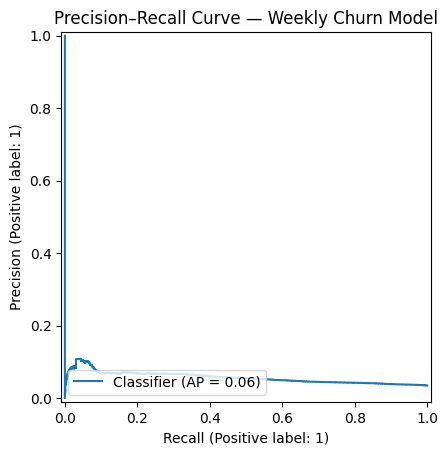

In [33]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

plt.figure()
PrecisionRecallDisplay.from_predictions(yte, proba)
plt.title("Precision–Recall Curve — Weekly Churn Model")
plt.show()


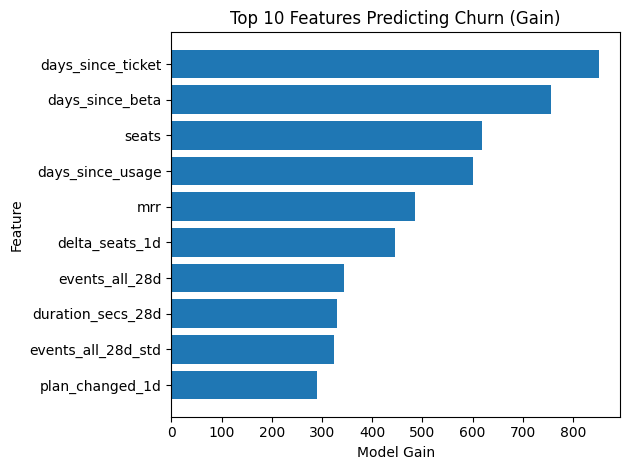

In [34]:
import matplotlib.pyplot as plt

top = fi.head(10)  # "feature","gain"

plt.figure()
plt.barh(top["feature"][::-1], top["gain"][::-1])
plt.title("Top 10 Features Predicting Churn (Gain)")
plt.xlabel("Model Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig('Top 10 Features')
plt.show()

